## BIG DATA COMPUNTING PROJECT
### Code Snippet Classification
### Emanuele Mercanti 1719869 and Andrea Trianni 1806198

# _____
### 0. Environment Setup

In [ ]:
# Download pyspark and install jdk

JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64" 

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf


In [ ]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '12G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Final check
spark

In [ ]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install last version of seaborn

!pip install --upgrade pip -q
!pip install seaborn==0.11 -q

     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 283 kB 5.9 MB/s 


In [ ]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import string 
import pickle
import re
from itertools import chain
import json
import gc
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql import functions as F

from pyspark.ml.feature import CountVectorizer, Tokenizer, RegexTokenizer
from pyspark.ml.feature import HashingTF, CountVectorizer, CountVectorizerModel,  IDF, IDFModel
from pyspark.ml import Pipeline

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import LogisticRegression , NaiveBayes, NaiveBayesModel, OneVsRest, OneVsRestModel,  LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel, LogisticRegressionModel, FMClassifier
from pyspark.ml.clustering import KMeans


from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

SEED = 42

In [ ]:
# Retrieve the datasets from the cloud

# !pip install gdown --q

! gdown -O ./snippets.csv    --id 1IMvnKKwFfaW7dB_SyGk7HjHGijH4LfmK
! gdown -O ./keywords.pickle --id 1Ri2yW83o93lYeabQiojDIn9RFMxmMVqQ

Downloading...
From: https://drive.google.com/uc?id=1IMvnKKwFfaW7dB_SyGk7HjHGijH4LfmK
To: /content/snippets.csv
1.79GB [00:09, 194MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ri2yW83o93lYeabQiojDIn9RFMxmMVqQ
To: /content/keywords.pickle
100% 5.64k/5.64k [00:00<00:00, 10.7MB/s]


# _____
### 1. Data exploration

In [ ]:
# Read the dataset from hdfs

schema = StructType([
    StructField("id", IntegerType()),
    StructField("snippet", StringType()),
    StructField("language", StringType()),
    StructField("repo_file_name", StringType()),
    StructField("github_repo_url", StringType()), 
    StructField("license", StringType()),
    StructField("commit_hash", StringType()),
    StructField("starting_line_number", IntegerType()),
    StructField("chuck_size", IntegerType())
])
        

data = spark.read.option("wholeFile", "true").csv(
    "./snippets.csv", 
    header=True, 
    schema=schema,
    sep=',',
    multiLine='true',
    escape = '"'
).select('language', 'snippet')

In [ ]:
# stratified split: this way we preserve the data distribution across splits
# 0.7 df (training set) / 0.1 val (validation set) / 0.2 test set

def stratify_split(data, SEED, fraction):
  fractions = data.select("language").distinct().withColumn("fraction", lit(fraction)).rdd.collectAsMap()                                                         
  train = data.stat.sampleBy("language", fractions, SEED)
  test =  data.subtract(train)
  return train, test

df, dummy = stratify_split(data, SEED, fraction=0.8)
test, val = stratify_split(dummy, SEED, fraction=0.5)
del dummy
gc.collect()

306

In [ ]:
# Print the schema and a sample

df.printSchema()
df.show(1)

root
 |-- language: string (nullable = true)
 |-- snippet: string (nullable = true)

+--------+--------------------+
|language|             snippet|
+--------+--------------------+
| DOTFILE|test/files/normal...|
+--------+--------------------+
only showing top 1 row



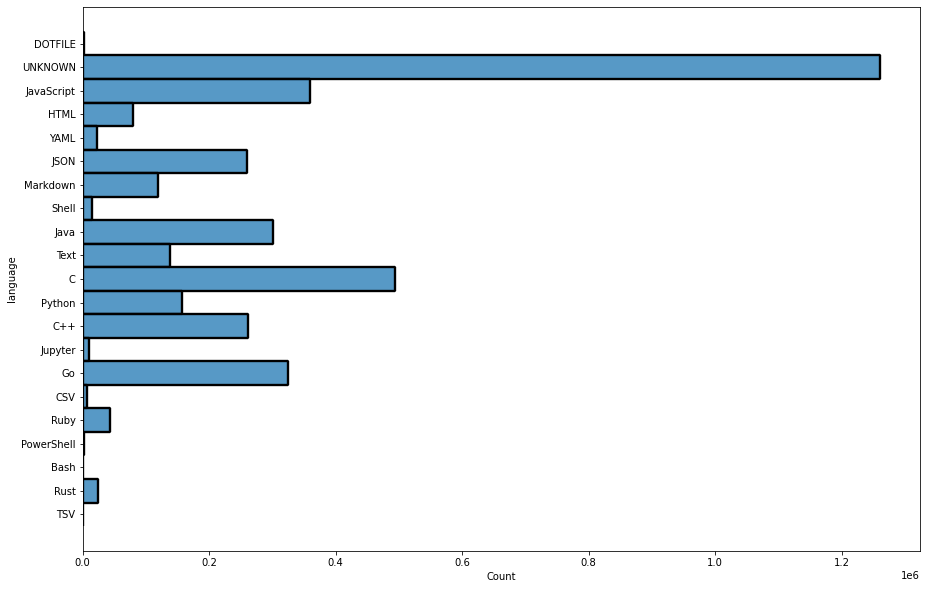

In [ ]:
# Class Balancing Plot
fig = plt.figure(figsize=(15, 10))

pandas_df = df.select('snippet', 'language').toPandas()
sns.histplot(data=pandas_df, y="language")
fig.savefig("/content/drive/MyDrive/big/fig/classes.png", transparent=True)

median 150.0 
mean 179.2494521437517 
std 930.2357596958163 
max 681867 
min 1 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


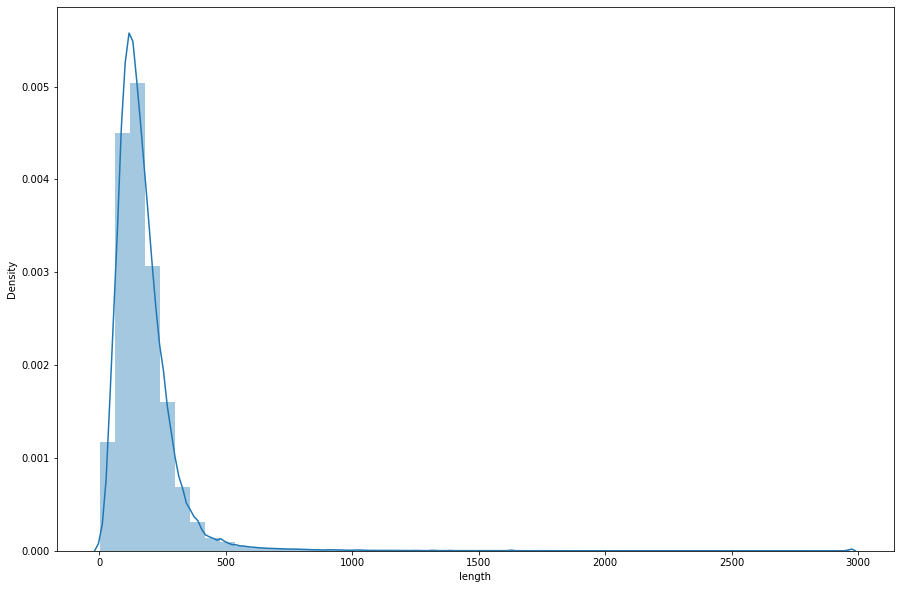

In [ ]:
# Snippet length Plot

pandas_df['length'] = pandas_df['snippet'].apply(lambda x: len(str(x)))

mean = pandas_df.length.mean()
std = pandas_df.length.std()

print('median', pandas_df.length.median(), '\n'
      'mean', pandas_df.length.mean(), '\n'
      'std', pandas_df.length.std(), '\n'
      'max', pandas_df.length.max(), '\n'
      'min', pandas_df.length.min(), '\n')

pandas_df['length'] = pandas_df['length'].apply(lambda x: x if x <= mean+3*std else mean+3*std)

fig = plt.figure(figsize=(15, 10))
sns.distplot(pandas_df['length'])
fig.savefig("/content/drive/MyDrive/big/fig/length.png", transparent=True)

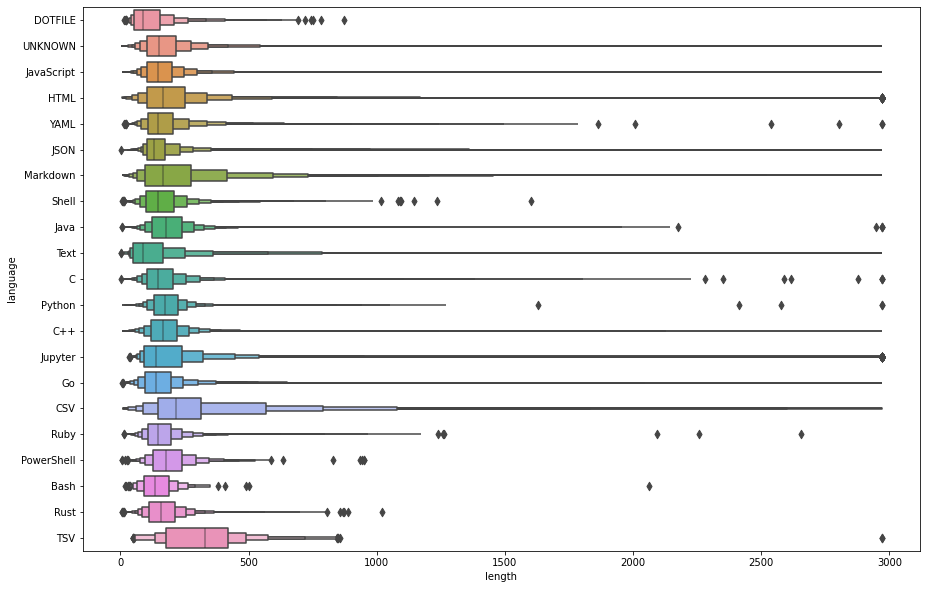

In [ ]:
# Boxen Plot

fig = plt.figure(figsize=(15, 10))
sns.boxenplot(y=pandas_df['language'], x=pandas_df['length'])
fig.savefig("/content/drive/MyDrive/big/fig/boxen.png", transparent=True)

# _____
### 2. Features engineering

#### 2.1 Data cleaning

In [ ]:
# Remove non programming language classes

remove_class = ['DOTFILE', 'YAML', 'Jupyter', 'CSV', 'JSON', 'TSV','UNKNOWN', "Markdown", 'Text']
df = df.filter(df.language.isin(remove_class) == False)

# Merge bash-family languages

df = df.withColumn('language', when(df.language.isin(['Shell', 'PowerShell', 'Bash']), 'shell').otherwise(df.language))

In [ ]:
# Removing outliers

df.createOrReplaceTempView("snippets")
df = spark.sql("SELECT * FROM snippets WHERE length(snippet) > 50 ")

In [ ]:
# Searching for missing values

df.where(col("snippet").isNull()).show()
df.where(col("language").isNull()).show()

+--------+-------+
|language|snippet|
+--------+-------+
+--------+-------+

+--------+-------+
|language|snippet|
+--------+-------+
+--------+-------+



In [ ]:
# Class weights calculation 

y_collect = df.select("language").groupBy("language").count().collect()
unique_y = [x["language"] for x in y_collect]

total_y = np.sum([ x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
df = df.withColumn("weight", mapping_expr.getItem(F.col("language")))

with open('/content/drive/MyDrive/big/pipe/class_weigths.json', 'w') as f:
  json.dump(class_weights_spark, f)

{'Rust': 8.589495184038528, 'JavaScript': 0.5747766437723536, 'C++': 0.7815658917155087, 'C': 0.41507751639989776, 'HTML': 2.723938418741648, 'shell': 11.954356672651107, 'Go': 0.6564226846131602, 'Ruby': 4.6637397273066865, 'Python': 1.2835068172764306, 'Java': 0.6723186488824268}


#### 2.2 Data Encoding
For the encoding part, we first try to manually build a vocabulary composed of the main keywords of each language that we load from a file on the disk. 
After building this vocabulary, we encoded the snippet using a BOW representation, that we perform even manually (no parallelization). 

This encoding, of course, is not very fast, but it has few dimensionalities, and allow the simplest model to perform quite well. Otherwise other complex models cannot squeeze their performance.
For these reasons, then, we moved to another type of tokenization and vectorization, that is powered by regex, parallelizable, and more sophisticated.

In the next cells you are going to see the first try of our project:

In [ ]:
# Class vocabulary declaration, commented since this encoding performance was bad

# class Vocabulary ():
  
#   def __init__(self):
#     self.vocab = {} #token -> id
#     self.add_token("UNK")
    
#   def add_token(self, token):
#     if token in self.vocab.keys():
#       return None
#     self.vocab[token] = len(self)
    
#   def get_token(self,index):
#     for token,idx in self.vocab.items():
#       if idx == index:
#         return token;
#     return "UNK";
  
#   def get_index(self, token):
#     if token not in self.vocab.keys():
#       return self.get_index("UNK");
#     return self.vocab[token]
    
#   def __len__(self):
#     return len(self.vocab)

  
#   #@classmethod
#   def from_disk(cls, path = "/tmp/keywords.pickle"):
#     with open(path, 'rb') as f:
#       keywords = pickle.load(f)
#     keywords += list(string.punctuation)
#     keywords += ['\n', '\t']
#     new_vocab = cls()
#     for token in keywords:
#       new_vocab.add_token(token)
#     return new_vocab
  

In [ ]:
# 1° Encoding strategy, commented since this encoding performance was bad

# my_dict = Vocabulary.from_disk()
# print(len(my_dict))

# def encode_manual_bow(string, my_dict):
#   encoded_list = [0.] * len(my_dict)
#   for token, idx in my_dict.vocab.items():
#     if (string is not None) and len(string) > 0:
#       encoded_list[idx] = string.lower().count(token.lower()) * 1. 

#   return encoded_list

# encode_udf = udf(lambda x: Vectors.dense(encode_manual_bow(x, my_dict)), VectorUDT())
# df = df.withColumn("encoded_manual_bow", encode_udf("snippet"))


This is instead the second encoding  (spark-based) strategy we decided to keep for our models.

The tokenizer is powered by a complex regex composed by 4 parts that are in boolean OR:
 <ul>
  <li> one to recognize { /t , /n }   ---   <i>[\\n\\t]</i></li>
  <li> the second recognize variables and keywords   ---  <i>([A-Za-z_]+\\b) </i></li>
  <li> the third recognize operators   ---   <i>[!\#\$%\&\*\+:\-\./<=>\?@\^_\|\~]+</i></li>
  <li> the last recognize tabs, spaces and Brackets   ---   <i>[ \(\),;\{\}\[\]`\"'])</i></li>
  </ul>

In [ ]:
# Regex Tokenization

pattern = "([\\n\\t]|([A-Za-z_]+\\b)|[!\#\$%\&\*\+:\-\./<=>\?@\^_\|\~]+|[ \(\),;\{\}\[\]`\"'])"

tokenizer = RegexTokenizer(inputCol="snippet", outputCol="tokenized", pattern=pattern, gaps=False)
df = tokenizer.transform(df)


In [ ]:
# BOW Vectorization -- Winner

cv = CountVectorizer(inputCol="tokenized", outputCol="bow_features", vocabSize=5000)
bow_vectorizer = cv.fit(df)
df = bow_vectorizer.transform(df)

# Save models
bow_vectorizer.save('/content/drive/MyDrive/big/pipe/bow_vectorizer.bin')

In [ ]:
# tf-idf Vectorization -- Looser

tf = CountVectorizer(inputCol='tokenized', outputCol="tf_features", vocabSize=10000, minDF=500)
tf_model = tf.fit(df)
df = tf_model.transform(df).cache()

idf = IDF(inputCol="tf_features", outputCol="tf_idf_features")
idf_model = idf.fit(df)
df = idf_model.transform(df).cache()

# Save models
tf_model.save('/content/drive/MyDrive/big/pipe/tf_model.bin')
idf_model.save('/content/drive/MyDrive/big/pipe/idf_model.bin')

In [ ]:
# Encoding the target

target_dict = {} ; i=0.0
classes = df.select('language').toPandas()
for el in classes.value_counts().index:
  target_dict[el[0]] = i
  i+=1.0
  
def encode_target(target, target_dict):
  return target_dict[target]

encode_target_udf = udf(lambda x: encode_target(x, target_dict), DoubleType())
df = df.withColumn("label", encode_target_udf("language"))

num_labels = len(target_dict)

with open('/content/drive/MyDrive/big/pipe/target_dict.json', 'w') as f:
  json.dump(target_dict, f)

In [ ]:
# Defining the pipelines

# load models and objects
class_weights = spark.read.json('/content/drive/MyDrive/big/pipe/class_weigths.json')
class_weights = json.loads(class_weights.toJSON().collect()[0])

target_dict = spark.read.json("/content/drive/MyDrive/big/pipe/target_dict.json")
target_dict = json.loads(target_dict.toJSON().collect()[0])
num_labels = len(target_dict)

bow_vectorizer = CountVectorizerModel.load('/content/drive/MyDrive/big/pipe/bow_vectorizer.bin')
tf_model = CountVectorizerModel.load('/content/drive/MyDrive/big/pipe/tf_model.bin')
idf_model = IDFModel.load('/content/drive/MyDrive/big/pipe/idf_model.bin')


def cleaning_pipeline(df, class_weights_spark):
  
  # remove classes
  remove_class = ['DOTFILE', 'YAML', 'Jupyter', 'CSV', 'JSON', 'TSV','UNKNOWN', "Markdown", 'Text']
  df = df.filter(df.language.isin(remove_class) == False)

  # Merge bash-family languages
  df = df.withColumn('language', when(df.language.isin(['Shell', 'PowerShell', 'Bash']), 'shell').otherwise(df.language))
  
  # remove outliers
  df.createOrReplaceTempView("snippets")
  df = spark.sql("SELECT * FROM snippets WHERE length(snippet) > 50")
  
  # class weights
  mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
  df = df.withColumn("weight", mapping_expr.getItem(F.col("language")))
  
  return df


def transforming_pipeline(df, target_dict, bow_vectorizer=None, tf_model=None, idf_model=None):
  
  # Regex Tokenization
  pattern = "([\\n\\t]|([A-Za-z_]+\\b)|[!\#\$%\&\*\+:\-\./<=>\?@\^_\|\~]+|[ \(\),;\{\}\[\]`\"'])"
  tokenizer = RegexTokenizer(inputCol="snippet", outputCol="tokenized", pattern=pattern, gaps=False)
  tokenized_df = tokenizer.transform(df)
  
  # Enconding snippet to vector
  if tf_model is not None:
    tokenized_df = tf_model.transform(tokenized_df).cache()
  
  if idf_model is not None:
    tokenized_df = idf_model.transform(tokenized_df).cache()
  
  if bow_vectorizer is not None:
    tokenized_df = bow_vectorizer.transform(tokenized_df).cache()
  
  
  # target encoding
  encode_target_udf = udf(lambda target: target_dict[target], DoubleType())
  encoded_df = tokenized_df.withColumn("label", encode_target_udf("language"))
  
  return encoded_df


In [ ]:
# Transform val and test

# in case we wanto to start from here and skip all the previous steps
# df = cleaning_pipeline(df, class_weights)
# df = transforming_pipeline(df, target_dict, bow_vectorizer)

val = cleaning_pipeline(val, class_weights)
val = transforming_pipeline(val, target_dict, bow_vectorizer)

test = cleaning_pipeline(test, class_weights)
test = transforming_pipeline(test, target_dict, bow_vectorizer)

features_col = 'bow_features'


# _____
### 3. Model selection

We are going to train 6 different models, we will select the best according to the performance obtained in validation set. 

We will us it until the end of the notebook

In [3]:
features_col = 'bow_features'
print(f'Data encoded with {features_col}')


# Our models
model_dict = {
  'nb': NaiveBayes(featuresCol=features_col, labelCol='label', weightCol="weight"),
  'lr': LogisticRegression(featuresCol=features_col, labelCol='label'),
  'dt': DecisionTreeClassifier(featuresCol=features_col, labelCol='label', weightCol="weight"),
  'rf':  RandomForestClassifier(featuresCol=features_col, labelCol='label', weightCol="weight"),
  'lsvc': OneVsRest(classifier=LinearSVC(featuresCol=features_col, labelCol='label', weightCol="weight"), 
                    featuresCol=features_col, labelCol='label', weightCol="weight"),

}


# Results are saved in a dictionary. When running the cell again the  
# dictionary is loaded and only the models not in the dictionary are trained
try:
    results = spark.read.json("/content/drive/MyDrive/big/bow_results_5k.json")
    results = json.loads(results.toJSON().collect()[0])

    print("Trained Models are:")
    for key in results.keys():
        print(f'{key} || scores: {results[key]}') 
        model_dict.pop(key)

except:
    results = dict()



# Training Code
print("Training Models:")
for model_name in model_dict.keys():
    
    print(f"working on model {model_name}")
    evaluator = MulticlassClassificationEvaluator()
    evaluator.setPredictionCol("prediction")
    
    model = model_dict[model_name].fit(df)
    pred = model.transform(val)
    if model_name == 'kmeans':
        pred_labels = pred.rdd.map(lambda pred: (float(pred.prediction), pred.label))
        metrics = MulticlassMetrics(pred_labels)
        results[model_name] = {'f1': metrics.weightedFMeasure(beta=1.), 'accuracy': metrics.accuracy}

    else:   
        results[model_name] = {
        'f1': evaluator.evaluate(pred.select('prediction', 'label'), {evaluator.metricName: "f1"}),
        'accuracy': evaluator.evaluate(pred.select('prediction', 'label'), {evaluator.metricName: "accuracy"})
        }
    
    with open('/content/drive/MyDrive/big/bow_results_5k.json', 'w') as f:
      json.dump(results, f)

    print(f'{model_name} || scores: {results[model_name]}') 

    # To help garbage Collector 
    del model; del pred; del evaluator; gc.collect()


Data encoded with bow_features
Trained Models are:
dt || scores: {'acuracy': 0.451108789972682, 'f1': 0.3846715183431253}
lr || scores: {'acuracy': 0.8347706536682915, 'f1': 0.8332280034756234}
lsvc || scores: {'acuracy': 0.8265886407056261, 'f1': 0.8279318354216001}
nb || scores: {'acuracy': 0.7373542592890174, 'f1': 0.7455214279472531}
rf || scores: {'acuracy': 0.5386290999339368, 'f1': 0.5571351407042987}


# _____
### 4. Model evaluation

In [ ]:
# Cross Validation + Grid Search
gc.collect()
lr = LogisticRegression(featuresCol=features_col, labelCol='label', weightCol="weight")

grid = ParamGridBuilder().addGrid(lr.elasticNetParam, [0.0, 0.5, 1]).addGrid(lr.regParam, [0.0, 1.]).build()
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

cv = CrossValidator(estimator=lr, evaluator=evaluator, estimatorParamMaps=grid, seed=SEED, numFolds=5)
cvModel = cv.fit(df)
cvModel.save("/content/drive/MyDrive/big/ml_models/cv_lr.bin")
print(f'f1: {cvModel.avgMetrics}') 
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

f1: [0.8253002849854882, 0.722112043662057, 0.8253002849854882, 0.002841071636609931, 0.8253002849854882, 0.002841071636609931]
{Param(parent='LogisticRegression_bd5a72fc330e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_bd5a72fc330e', name='regParam', doc='regularization parameter (>= 0).'): 0.0}


In [ ]:
lr = LogisticRegression(featuresCol=features_col, labelCol='label', weightCol="weight")
model = lr.fit(df)

model.save("/content/drive/MyDrive/big/ml_models/lrModel.bin")

In [ ]:
# Benchmark on test set
model = LogisticRegressionModel().load("/content/drive/MyDrive/big/ml_models/lrModel.bin")
pred = model.transform(test)

evaluator = MulticlassClassificationEvaluator()
evaluator.setPredictionCol("prediction")

print('f1:', evaluator.evaluate(pred.select('prediction', 'label'), {evaluator.metricName: "f1"}))
print('accuracy:', evaluator.evaluate(pred.select('prediction', 'label'), {evaluator.metricName: "accuracy"}))

f1: 0.8219925886336438
accuracy: 0.8204051240207422


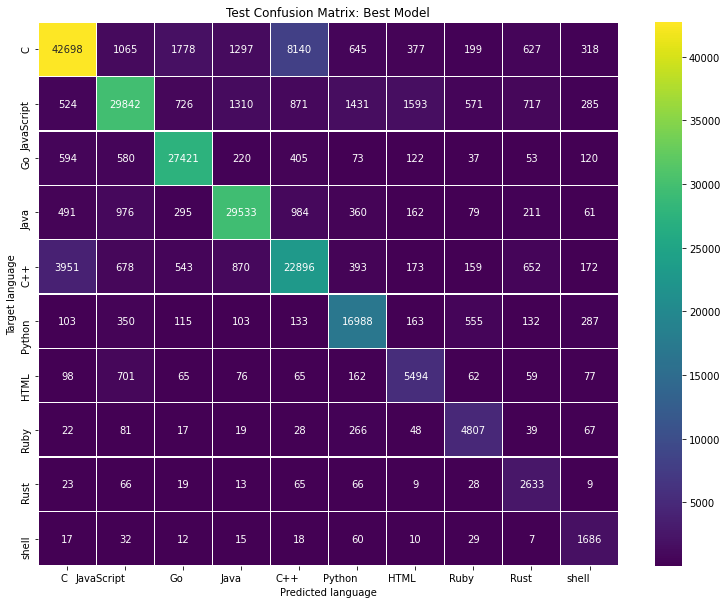

<Figure size 432x288 with 0 Axes>

In [ ]:
# confusion matrix

def plot_cm(y_pred, y_target, model_name, classes, features_col):
    fig, ax = plt.subplots(figsize=(13,10))  
    cm = confusion_matrix(y_target, y_pred)
    df_cm = pd.DataFrame(cm,index=classes, columns=classes)
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="viridis",linewidths=.4)

    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
    plt.ylabel('Target language')
    plt.xlabel('Predicted language')
    plt.title("Test Confusion Matrix: "+model_name)

    plt.show()
    filename = features_col + '_' + model_name + '_cm.png'
    fig.savefig('/content/drive/MyDrive/big/fig/' + filename, transparent=True)
    plt.cla(); plt.clf()

def order_classes(dict):
    classes = []
    for i in range(10):
        for key in target_dict.keys():
            if target_dict[key] == float(i):
                classes.append(key)
    return classes
# classes = [ str(x[0]) for x in df.select('language').distinct().collect()]
classes = order_classes(target_dict)
y_label = [ str(x[0]) for x in pred.select('label').collect()]
y_pred  = [ str(x[0]) for x in pred.select('prediction').collect()]

plot_cm(y_pred, y_label, "Best Model", classes, features_col)


working on split 0.25
working on split 0.5
working on split 0.75
working on split 1.0


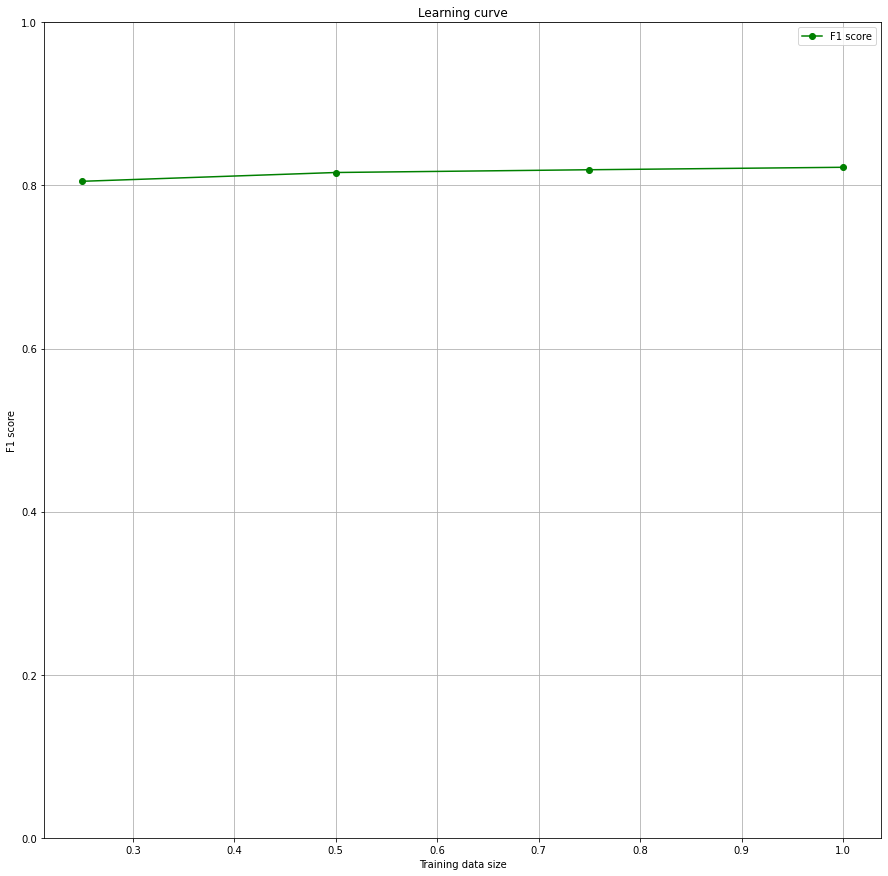

In [ ]:
# learning curve

def train_multiple_sizes(data, val, splits = [0.25, 0.5, 0.75, 1.0]):

    all_scores = pd.DataFrame(columns = [ 'train_size', 'score'])
  
    for size in splits:
        print('working on split', size)
        split_train, _ = stratify_split(data, SEED, fraction=size)

        model = LogisticRegression(featuresCol=features_col, labelCol='label', weightCol="weight")
        fitted_model = model.fit(split_train)
        pred = fitted_model.transform(val)

        evaluator = MulticlassClassificationEvaluator()
        evaluator.setPredictionCol("prediction")
        score = evaluator.evaluate(pred.select('prediction', 'label'), {evaluator.metricName: "f1"})
                                
        all_scores = all_scores.append({ 'train_size': size, 'score': score}, ignore_index = True)
        gc.collect()
    all_scores.to_csv('/content/drive/MyDrive/big/fig/learning_curve_data.csv')
    return all_scores



def plot_learning_curve(all_scores, colors):

    fig, ax = plt.subplots(figsize=(15, 15))
    size = all_scores['train_size'].tolist()
    score = all_scores['score'].tolist()
    ax.plot(size, score, 'o-', color = colors[0], label = "F1 score")

    plt.grid()
    plt.ylim(0.0,1.0)
    plt.legend(loc="best")
    plt.title("Learning curve")
    plt.ylabel("F1 score")
    plt.xlabel("Training data size")
    plt.show()
    fig.savefig('/content/drive/MyDrive/big/fig/learning_curve.png', transparent=True)                               

        
all_scores = train_multiple_sizes(df, val)
plot_learning_curve(all_scores, ['green', 'black', 'coral', 'blue', 'orchid', 'yellow'])                

# _____
### 5. WebApp

To use the webapp and play with the trained model, open the other notebook!
